In [1]:
import pandas as pd

data = pd.read_csv("automated_data.csv")
print(data.head())
print(data.shape)

   delays_on  norm_signal_on  std_dev_on  delays_off  norm_signal_off  \
0       26.0        3.026141    0.240502        26.0         2.541667   
1       28.0        1.880862    0.224274        28.0         2.357153   
2       30.0        1.400611    0.226023        30.0         2.328197   
3       32.0        1.517770    0.224060        32.0         2.625267   
4       34.0        2.374336    0.231888        34.0         2.550722   

   std_dev_off  relative_p_values  
0     0.212023           0.130771  
1     0.199654           0.112688  
2     0.203034           0.002265  
3     0.203059           0.000250  
4     0.207084           0.570478  
(13, 7)


In [20]:
import pyro
import pyro.distributions as dist

def physics_model(t, t0, tp, A, B, a, b, d):
    return A * torch.exp(-a * (t - t0)) + B * torch.exp(-d * (t - t0)) * torch.sin(b * (t - t0 + tp))

In [21]:



def model(t, sigma_on, obs):
    t0 = pyro.sample("t0", dist.Normal(25.0, 2.0))
    tp = pyro.sample("tp", dist.Normal(0.0, 10))
    A = pyro.sample("A", dist.Normal(2.0, .5))
    B = pyro.sample("B", dist.Normal(1, .5))
    a = pyro.sample("a", dist.HalfNormal(0.01))
    b = pyro.sample("b", dist.HalfNormal(.5))
    d = pyro.sample("d", dist.HalfNormal(0.1))

    with pyro.plate("data", len(t)):
        y_on_true = physics_model(t, t0, tp, A, B, a, b, d)
#         y_off_true = physics_model(t, t0, tp, A, B, a, b, d)

        y_on_obs = pyro.sample("y_on", dist.Normal(y_on_true, sigma_on), obs=obs)
#         y_off_obs = pyro.sample("y_off", dist.Normal(y_off_true, sigma_off), obs=norm_signal_off)
        
    return y_on_obs#, y_off_obs



In [22]:
import pandas as pd
import torch
df = pd.read_csv('automated_data.csv')

# Prepare data
delays = torch.tensor(df["delays_on"].values)
norm_signal_on = torch.tensor(df["norm_signal_on"].values)
std_dev_on = torch.tensor(df["std_dev_on"].values)
norm_signal_off = torch.tensor(df["norm_signal_off"].values)
std_dev_off = torch.tensor(df["std_dev_off"].values)

In [23]:
from pyro.infer import MCMC, NUTS

In [24]:
num_samples = 2000
warmup_steps = 200
num_chains = 1

kernel = NUTS(model)
mcmc = MCMC(kernel, num_samples=num_samples, warmup_steps=warmup_steps, num_chains=num_chains)

In [25]:
mcmc.run(delays, sigma_on=std_dev_on, obs = norm_signal_on)

# alternate codepath: delay_off TODO refactor
# mcmc.run(delays, sigma_on=std_dev_off, obs = norm_signal_off)

Sample: 100%|████████████████████████████████████████| 2200/2200 [02:27, 14.95it/s, step size=9.05e-02, acc. prob=0.930]                                                                                    


In [26]:
# Extract the samples from the MCMC trace
t0_samples = mcmc.get_samples()["t0"].flatten()
tp_samples = mcmc.get_samples()["tp"].flatten()
A_samples = mcmc.get_samples()["A"].flatten()
B_samples = mcmc.get_samples()["B"].flatten()
a_samples = mcmc.get_samples()["a"].flatten()
b_samples = mcmc.get_samples()["b"].flatten()
d_samples = mcmc.get_samples()["d"].flatten()

# Calculate the mean and standard deviation of the samples for each parameter
t0_mean = torch.mean(t0_samples)
t0_std = torch.std(t0_samples)

tp_mean = torch.mean(tp_samples)
tp_std = torch.std(tp_samples)

A_mean = torch.mean(A_samples)
A_std = torch.std(A_samples)

B_mean = torch.mean(B_samples)
B_std = torch.std(B_samples)

a_mean = torch.mean(a_samples)
a_std = torch.std(a_samples)

b_mean = torch.mean(b_samples)
b_std = torch.std(b_samples)

d_mean = torch.mean(d_samples)
d_std = torch.std(d_samples)

# Print the summary
print("Parameter Means:")
print(f"t0: {t0_mean:.3f}")
print(f"tp: {tp_mean:.3f}")
print(f"A: {A_mean:.3f}")
print(f"B: {B_mean:.3f}")
print(f"a: {a_mean:.3f}")
print(f"b: {b_mean:.3f}")
print(f"d: {d_mean:.3f}")

print("\nParameter Standard Deviations:")
print(f"t0: {t0_std:.3f}")
print(f"tp: {tp_std:.3f}")
print(f"A: {A_std:.3f}")
print(f"B: {B_std:.3f}")
print(f"a: {a_std:.3f}")
print(f"b: {b_std:.3f}")
print(f"d: {d_std:.3f}")

Parameter Means:
t0: 24.917
tp: 2.183
A: 2.131
B: 1.112
a: 0.004
b: 0.647
d: 0.107

Parameter Standard Deviations:
t0: 1.807
tp: 2.607
A: 0.115
B: 0.308
a: 0.003
b: 0.109
d: 0.045


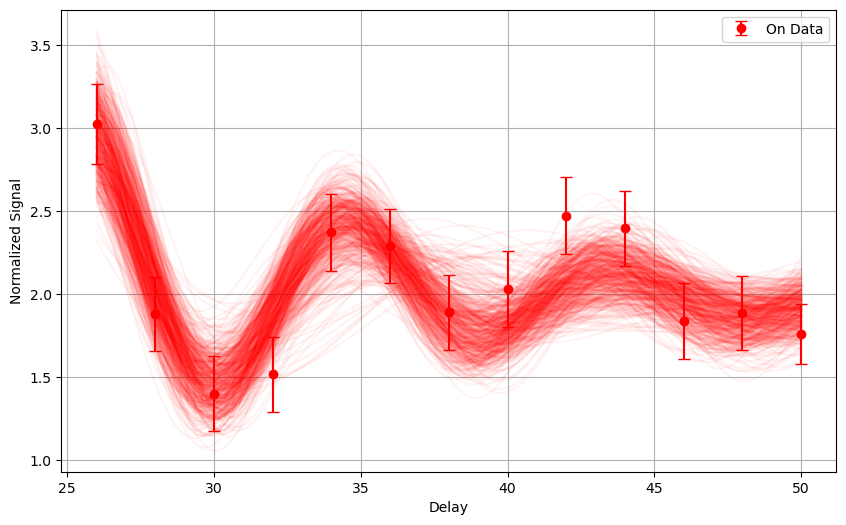

In [28]:
import matplotlib.pyplot as plt

t_pred = torch.linspace(delays.min(), delays.max(), 100)
y_on_pred = torch.zeros((num_samples, len(t_pred)))
y_off_pred = torch.zeros((num_samples, len(t_pred)))

for i in range(num_samples - 500, num_samples):
    y_on_pred[i] = physics_model(t_pred, t0_samples[i], tp_samples[i], A_samples[i], B_samples[i], a_samples[i], b_samples[i], d_samples[i])
#     y_off_pred[i] = physics_model(t_pred, t0_samples[i], tp_samples[i], A_samples[i], B_samples[i], a_samples[i], b_samples[i], d_samples[i])

plt.figure(figsize=(10, 6))
plt.errorbar(delays.numpy(), norm_signal_on.numpy(), yerr=std_dev_on.numpy(), fmt='ro', capsize=4, label='On Data')
# plt.errorbar(delays.numpy(), norm_signal_off.numpy(), yerr=std_dev_off.numpy(), fmt='bo', capsize=4, label='Off Data')

for i in range(num_samples - 500, num_samples):
    plt.plot(t_pred.numpy(), y_on_pred[i].numpy(), 'r-', alpha=0.05)
#     plt.plot(t_pred.numpy(), y_off_pred[i].numpy(), 'b-', alpha=0.05)

plt.xlabel('Delay')
plt.ylabel('Normalized Signal')
plt.grid()
plt.legend()
plt.show()


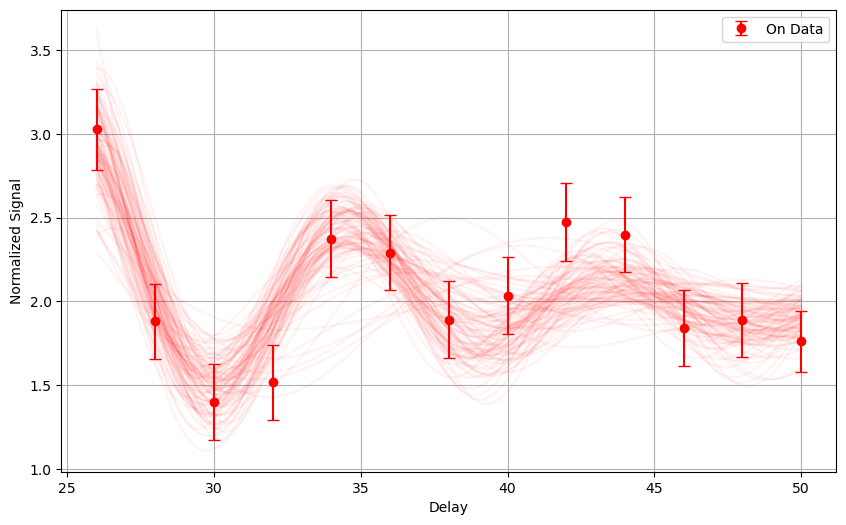

In [14]:
import matplotlib.pyplot as plt

t_pred = torch.linspace(delays.min(), delays.max(), 100)
y_on_pred = torch.zeros((num_samples, len(t_pred)))
y_off_pred = torch.zeros((num_samples, len(t_pred)))

for i in range(num_samples - 100, num_samples):
    y_on_pred[i] = physics_model(t_pred, t0_samples[i], tp_samples[i], A_samples[i], B_samples[i], a_samples[i], b_samples[i], d_samples[i])
#     y_off_pred[i] = physics_model(t_pred, t0_samples[i], tp_samples[i], A_samples[i], B_samples[i], a_samples[i], b_samples[i], d_samples[i])

plt.figure(figsize=(10, 6))
plt.errorbar(delays.numpy(), norm_signal_on.numpy(), yerr=std_dev_on.numpy(), fmt='ro', capsize=4, label='On Data')
# plt.errorbar(delays.numpy(), norm_signal_off.numpy(), yerr=std_dev_off.numpy(), fmt='bo', capsize=4, label='Off Data')

for i in range(num_samples - 100, num_samples):
    plt.plot(t_pred.numpy(), y_on_pred[i].numpy(), 'r-', alpha=0.05)
#     plt.plot(t_pred.numpy(), y_off_pred[i].numpy(), 'b-', alpha=0.05)

plt.xlabel('Delay')
plt.ylabel('Normalized Signal')
plt.grid()
plt.legend()
plt.show()


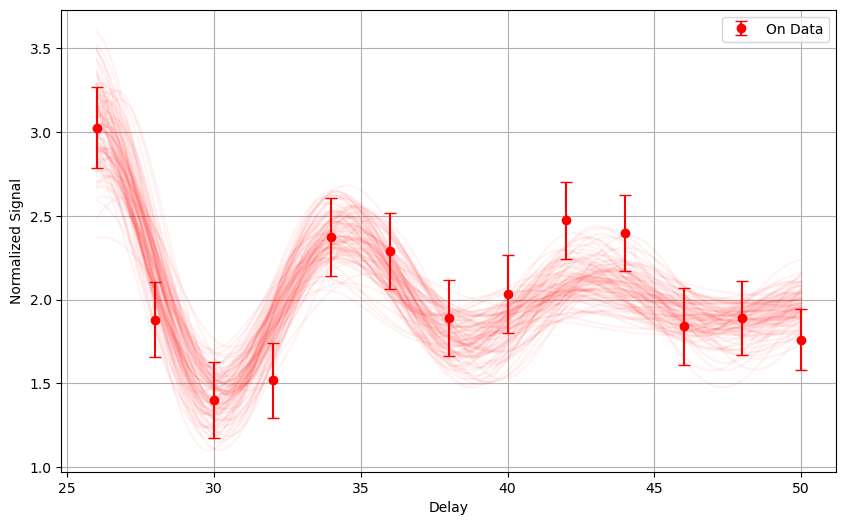

In [41]:
import matplotlib.pyplot as plt

t_pred = torch.linspace(delays.min(), delays.max(), 100)
y_on_pred = torch.zeros((num_samples, len(t_pred)))
y_off_pred = torch.zeros((num_samples, len(t_pred)))

for i in range(num_samples - 100, num_samples):
    y_on_pred[i] = physics_model(t_pred, t0_samples[i], tp_samples[i], A_samples[i], B_samples[i], a_samples[i], b_samples[i], d_samples[i])
#     y_off_pred[i] = physics_model(t_pred, t0_samples[i], tp_samples[i], A_samples[i], B_samples[i], a_samples[i], b_samples[i], d_samples[i])

plt.figure(figsize=(10, 6))
plt.errorbar(delays.numpy(), norm_signal_on.numpy(), yerr=std_dev_on.numpy(), fmt='ro', capsize=4, label='On Data')
# plt.errorbar(delays.numpy(), norm_signal_off.numpy(), yerr=std_dev_off.numpy(), fmt='bo', capsize=4, label='Off Data')

for i in range(num_samples - 100, num_samples):
    plt.plot(t_pred.numpy(), y_on_pred[i].numpy(), 'r-', alpha=0.05)
#     plt.plot(t_pred.numpy(), y_off_pred[i].numpy(), 'b-', alpha=0.05)

plt.xlabel('Delay')
plt.ylabel('Normalized Signal')
plt.grid()
plt.legend()
plt.show()


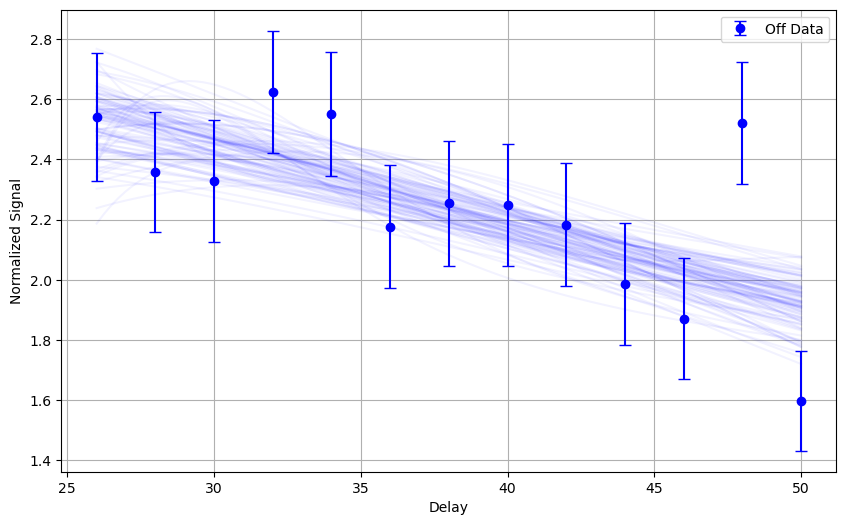

In [77]:
import matplotlib.pyplot as plt

t_pred = torch.linspace(delays.min(), delays.max(), 100)
y_on_pred = torch.zeros((num_samples, len(t_pred)))
y_off_pred = torch.zeros((num_samples, len(t_pred)))

for i in range(num_samples - 100, num_samples):
#     y_on_pred[i] = physics_model(t_pred, t0_samples[i], tp_samples[i], A_samples[i], B_samples[i], a_samples[i], b_samples[i], d_samples[i])
    y_off_pred[i] = physics_model(t_pred, t0_samples[i], tp_samples[i], A_samples[i], B_samples[i], a_samples[i], b_samples[i], d_samples[i])

plt.figure(figsize=(10, 6))
# plt.errorbar(delays.numpy(), norm_signal_on.numpy(), yerr=std_dev_on.numpy(), fmt='ro', capsize=4, label='On Data')
plt.errorbar(delays.numpy(), norm_signal_off.numpy(), yerr=std_dev_off.numpy(), fmt='bo', capsize=4, label='Off Data')

for i in range(num_samples - 100, num_samples):
#     plt.plot(t_pred.numpy(), y_on_pred[i].numpy(), 'r-', alpha=0.05)
    plt.plot(t_pred.numpy(), y_off_pred[i].numpy(), 'b-', alpha=0.05)

plt.xlabel('Delay')
plt.ylabel('Normalized Signal')
plt.grid()
plt.legend()
plt.show()


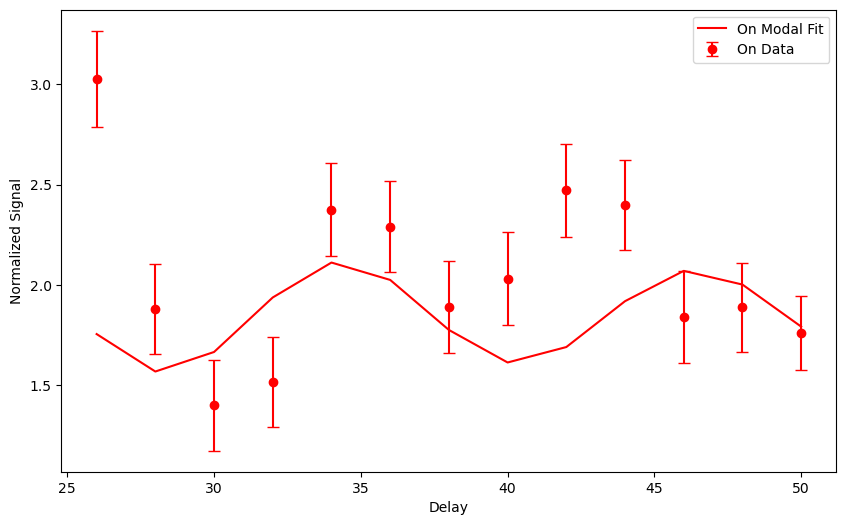

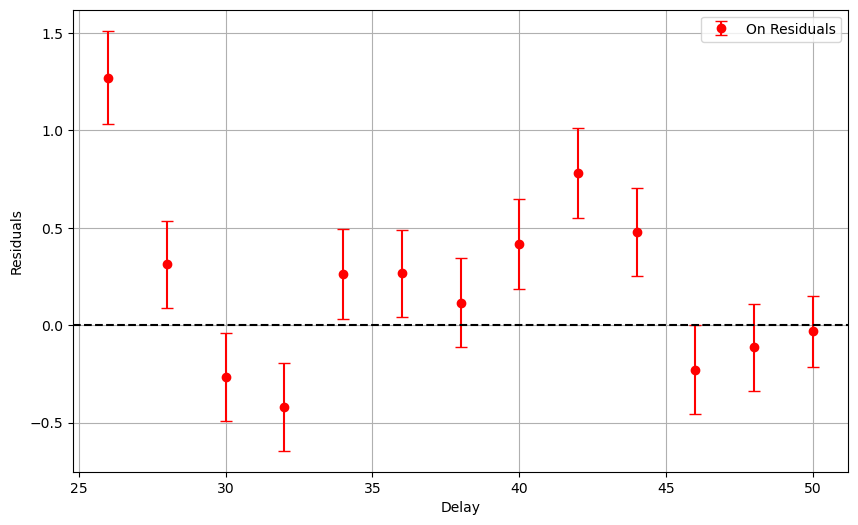

In [47]:
# # Plot the modal fit and data points with error bars
# plt.figure(figsize=(10, 6))
# plt.errorbar(delays.numpy(), norm_signal_on.numpy(), yerr=std_dev_on.numpy(), fmt='ro', capsize=4, label='On Data')
# # plt.errorbar(delays.numpy(), norm_signal_off.numpy(), yerr=std_dev_off.numpy(), fmt='bo', capsize=4, label='Off Data')
# plt.plot(delays.numpy(), y_on_modal.numpy(), 'r-', label='On Modal Fit')
# # plt.plot(delays.numpy(), y_off_modal.numpy(), 'b-', label='Off Modal Fit')
# plt.xlabel('Delay')
# plt.ylabel('Normalized Signal')
# plt.legend()
# plt.show()

# # Plot the residuals
# plt.figure(figsize=(10, 6))
# plt.errorbar(delays.numpy(), residuals_on.numpy(), yerr=std_dev_on.numpy(), fmt='ro', capsize=4, label='On Residuals')
# # plt.errorbar(delays.numpy(), residuals_off.numpy(), yerr=std_dev_off.numpy(), fmt='bo', capsize=4, label='Off Residuals')
# plt.axhline(y=0, color='black', linestyle='--')
# plt.grid()
# plt.xlabel('Delay')
# plt.ylabel('Residuals')
# plt.legend()
# plt.show()

In [27]:
# Find the joint posterior mode
joint_samples = torch.stack([t0_samples, tp_samples, A_samples, B_samples, a_samples, b_samples, d_samples], dim=1)
_, mode_indices = torch.mode(joint_samples, dim=0)
mode_index = mode_indices[0]

t0_mode = t0_samples[mode_index]
tp_mode = tp_samples[mode_index]
A_mode = A_samples[mode_index]
B_mode = B_samples[mode_index]
a_mode = a_samples[mode_index]
b_mode = b_samples[mode_index]
d_mode = d_samples[mode_index]

In [28]:
y_on_modal = physics_model(delays, t0_mode, tp_mode, A_mode, B_mode, a_mode, b_mode, d_mode)
residuals_on = norm_signal_on - y_on_modal


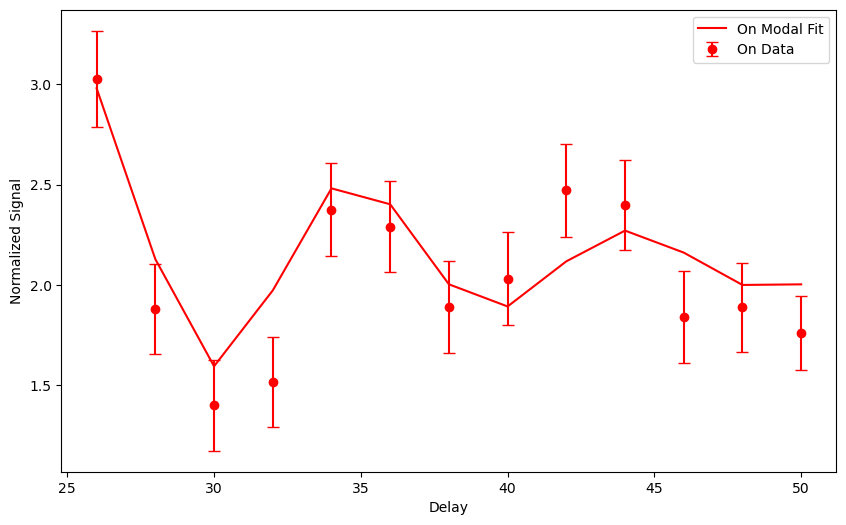

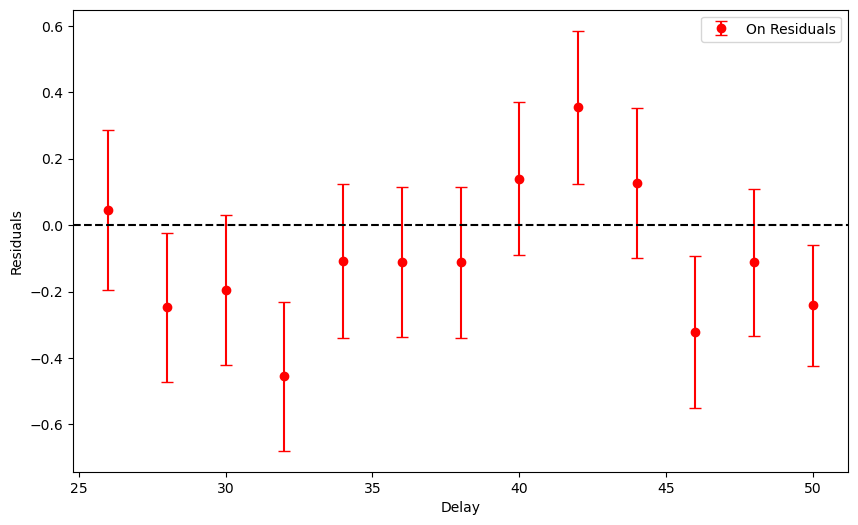

In [30]:
# Plot the modal fit and data points with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(delays.numpy(), norm_signal_on.numpy(), yerr=std_dev_on.numpy(), fmt='ro', capsize=4, label='On Data')
# plt.errorbar(delays.numpy(), norm_signal_off.numpy(), yerr=std_dev_off.numpy(), fmt='bo', capsize=4, label='Off Data')
plt.plot(delays.numpy(), y_on_modal.numpy(), 'r-', label='On Modal Fit')
# plt.plot(delays.numpy(), y_off_modal.numpy(), 'b-', label='Off Modal Fit')
plt.xlabel('Delay')
plt.ylabel('Normalized Signal')
plt.legend()
plt.show()

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.errorbar(delays.numpy(), residuals_on.numpy(), yerr=std_dev_on.numpy(), fmt='ro', capsize=4, label='On Residuals')
# plt.errorbar(delays.numpy(), residuals_off.numpy(), yerr=std_dev_off.numpy(), fmt='bo', capsize=4, label='Off Residuals')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Delay')
plt.ylabel('Residuals')
plt.legend()
plt.show()

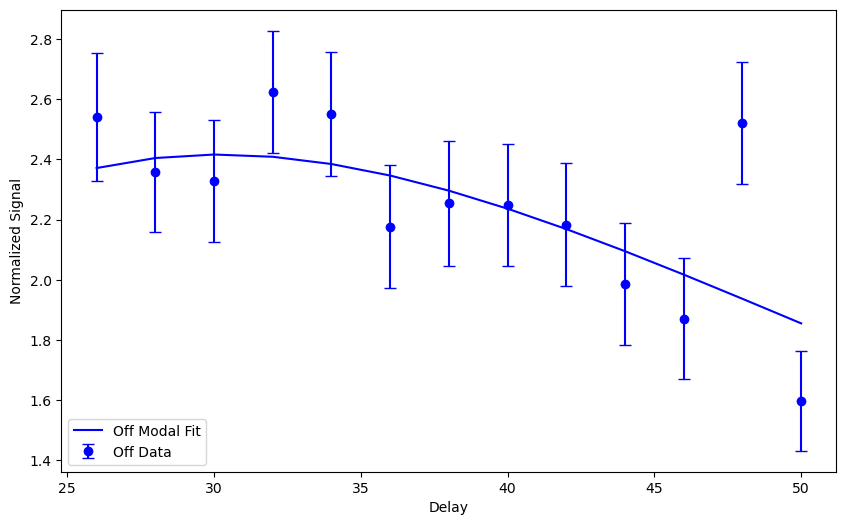

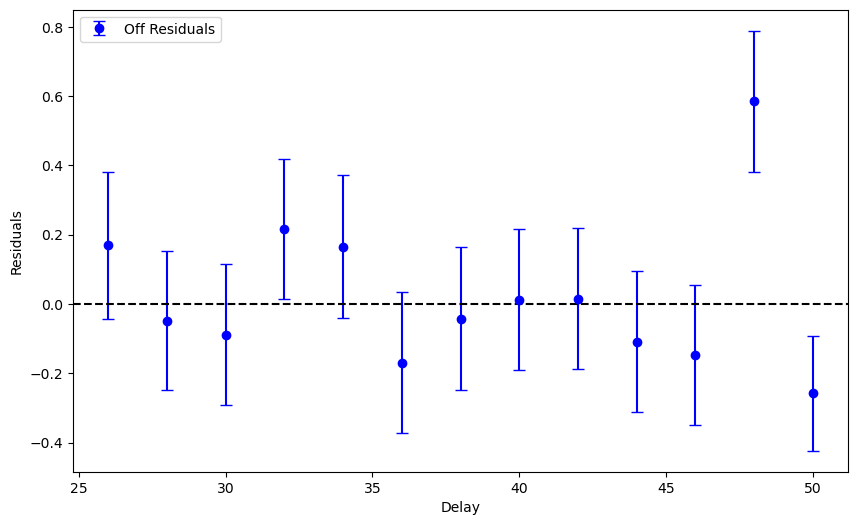

In [81]:
# Plot the modal fit and data points with error bars
plt.figure(figsize=(10, 6))
# plt.errorbar(delays.numpy(), norm_signal_on.numpy(), yerr=std_dev_on.numpy(), fmt='ro', capsize=4, label='On Data')
plt.errorbar(delays.numpy(), norm_signal_off.numpy(), yerr=std_dev_off.numpy(), fmt='bo', capsize=4, label='Off Data')
# plt.plot(delays.numpy(), y_on_modal.numpy(), 'r-', label='On Modal Fit')
plt.plot(delays.numpy(), y_off_modal.numpy(), 'b-', label='Off Modal Fit')
plt.xlabel('Delay')
plt.ylabel('Normalized Signal')
plt.legend()
plt.show()

# Plot the residuals
plt.figure(figsize=(10, 6))
# plt.errorbar(delays.numpy(), residuals_on.numpy(), yerr=std_dev_on.numpy(), fmt='ro', capsize=4, label='On Residuals')
plt.errorbar(delays.numpy(), residuals_off.numpy(), yerr=std_dev_off.numpy(), fmt='bo', capsize=4, label='Off Residuals')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Delay')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import matplotlib.pyplot as plt

def physics_model(t, t0, tp, A, B, a, b, d):
    return A * torch.exp(-a * (t - t0)) + B * torch.exp(-d * (t - t0)) * torch.sin(b * (t - t0 + tp))

def model(t, sigma, obs):
    t0 = pyro.sample("t0", dist.Normal(25.0, 2.0))
    tp = pyro.sample("tp", dist.Normal(0.0, 10))
    A = pyro.sample("A", dist.Normal(2.0, 0.5))
    B = pyro.sample("B", dist.Normal(1, 0.5))
    a = pyro.sample("a", dist.HalfNormal(0.01))
    b = pyro.sample("b", dist.HalfNormal(0.5))
    d = pyro.sample("d", dist.HalfNormal(0.1))

    with pyro.plate("data", len(t)):
        y_true = physics_model(t, t0, tp, A, B, a, b, d)
        y_obs = pyro.sample("y", dist.Normal(y_true, sigma), obs=obs)
        
    return y_obs

def run_mcmc(model, delays, sigma, obs, num_samples=2000, warmup_steps=200, num_chains=1):
    kernel = NUTS(model)
    mcmc = MCMC(kernel, num_samples=num_samples, warmup_steps=warmup_steps, num_chains=num_chains)
    mcmc.run(delays, sigma=sigma, obs=obs)
    return mcmc

def plot_results(mcmc, delays, obs, sigma, num_plot_samples=100):
    t_pred = torch.linspace(delays.min(), delays.max(), 100)
    y_pred = torch.zeros((num_plot_samples, len(t_pred)))

    t0_samples = mcmc.get_samples()["t0"].flatten()
    tp_samples = mcmc.get_samples()["tp"].flatten()
    A_samples = mcmc.get_samples()["A"].flatten()
    B_samples = mcmc.get_samples()["B"].flatten()
    a_samples = mcmc.get_samples()["a"].flatten()
    b_samples = mcmc.get_samples()["b"].flatten()
    d_samples = mcmc.get_samples()["d"].flatten()

    for i in range(-num_plot_samples, 0):
        y_pred[i] = physics_model(t_pred, t0_samples[i], tp_samples[i], A_samples[i], B_samples[i], a_samples[i], b_samples[i], d_samples[i])

    plt.figure(figsize=(10, 6))
    plt.errorbar(delays.numpy(), obs.numpy(), yerr=sigma.numpy(), fmt='ro', capsize=4, label='Data')

    for i in range(-num_plot_samples, 0):
        plt.plot(t_pred.numpy(), y_pred[i].numpy(), 'r-', alpha=0.05)

    plt.xlabel('Delay')
    plt.ylabel('Normalized Signal')
    plt.grid()
    plt.legend()
    plt.show()

    # Find the joint posterior mode TODO this might be wrong
    joint_samples = torch.stack([t0_samples, tp_samples, A_samples, B_samples, a_samples, b_samples, d_samples], dim=1)
    _, mode_indices = torch.mode(joint_samples, dim=0)
    mode_index = mode_indices[0]

    t0_mode = t0_samples[mode_index]
    tp_mode = tp_samples[mode_index]
    A_mode = A_samples[mode_index]
    B_mode = B_samples[mode_index]
    a_mode = a_samples[mode_index]
    b_mode = b_samples[mode_index]
    d_mode = d_samples[mode_index]

    y_modal = physics_model(delays, t0_mode, tp_mode, A_mode, B_mode, a_mode, b_mode, d_mode)
    residuals = obs - y_modal

    # Plot the modal fit and data points with error bars
    plt.figure(figsize=(10, 6))
    plt.errorbar(delays.numpy(), obs.numpy(), yerr=sigma.numpy(), fmt='ro', capsize=4, label='Data')
    plt.plot(delays.numpy(), y_modal.numpy(), 'r-', label='Modal Fit')
    plt.xlabel('Delay')
    plt.ylabel('Normalized Signal')
    plt.legend()
    plt.show()

    # Plot the residuals
    plt.figure(figsize=(10, 6))
    plt.errorbar(delays.numpy(), residuals.numpy(), yerr=sigma.numpy(), fmt='ro', capsize=4, label='Residuals')
    plt.axhline(y=0, color='black', linestyle='--')
    plt.xlabel('Delay')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show()

def main():
    df = pd.read_csv('automated_data.csv')

    delays = torch.tensor(df["delays_on"].values)
    norm_signal_on = torch.tensor(df["norm_signal_on"].values)
    std_dev_on = torch.tensor(df["std_dev_on"].values)
    norm_signal_off = torch.tensor(df["norm_signal_off"].values)
    std_dev_off = torch.tensor(df["std_dev_off"].values)

    print("Running MCMC on 'on' data...")
    mcmc_on = run_mcmc(model, delays, std_dev_on, norm_signal_on)
    print("Running MCMC on 'off' data...")
    mcmc_off = run_mcmc(model, delays, std_dev_off, norm_signal_off)

    print("Plotting results for 'on' data...")
    plot_results(mcmc_on, delays, norm_signal_on, std_dev_on)
    print("Plotting results for 'off' data...")
    plot_results(mcmc_off, delays, norm_signal_off, std_dev_off)

if __name__ == "__main__":
    main()